In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
from typing import Tuple
import subprocess

In [2]:
# Run the simulation: e.g.
# subprocess.run(["cargo", "run", "--release"])

In [3]:
# Load output
df_raw = pl.read_json("../output.json")

In [4]:
def process_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    # Processes raw dataframe of serialized JSON
    return (
        df.melt()
        .unnest("value")
        .explode(pl.col("*").exclude("variable"))
        .unnest("positions")
        .rename({"times": "time"})
        .unnest("trajectory")
        .unnest("S")
        .unnest("R")
        .select(
            [
                pl.col("variable").cast(pl.UInt64).alias("agent_id"),
                pl.all().exclude(["variable", "val"]),
                pl.col("val").alias("reward"),
            ]
        )
    )


def add_dummies(df: pl.DataFrame) -> pl.DataFrame:
    # Adds OHE for action
    return pl.concat(
        [
            df.select(pl.all().exclude("A")),
            df.select(["A"])
            .to_dummies(columns=["A"], drop_first=False)
            .with_columns(
                cs.contains("A_").map_alias(lambda col_name: col_name.lstrip("A_"))
            )
            .select(pl.all().exclude("^A_.*$")),
        ],
        how="horizontal",
    )

In [5]:
# Process raw data, add time, add dummies for actions, unnest trades
df = add_dummies(process_raw_data(df_raw)).unnest("trades")

In [6]:
# Print head
df.head()

agent_id,food,water,min_steps_to_food,min_steps_to_water,min_steps_to_trader,time,x,y,id,offer,reward,Stationary,ToAgent,ToFood,ToWater
u64,i64,i64,i64,i64,i64,i64,i64,i64,i64,list[i64],i64,u8,u8,u8,u8
0,0,0,2,20,0,0,16,14,null,null,-2,0,1,0,0
0,10,-10,2,20,0,10,14,16,null,null,-11,0,1,0,0
0,0,-20,2,20,0,20,16,15,null,null,-22,0,0,1,0
0,20,-30,3,19,0,30,14,15,null,null,-31,0,1,0,0
0,20,-40,1,21,0,40,15,16,null,null,-41,0,1,0,0


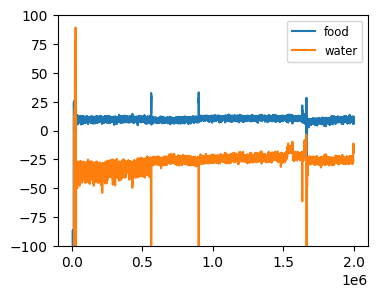

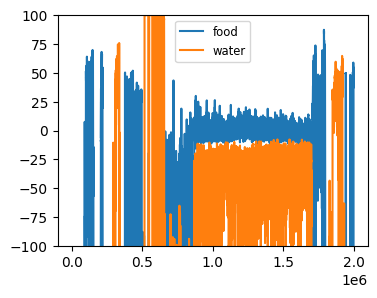

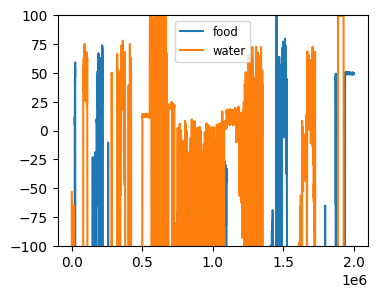

In [7]:
def plot_food_and_water(df: pl.DataFrame, agent_idx: int, window_size: int = 100):
    # Get smoothed versions
    av = (
        df.groupby(["agent_id"], maintain_order=True)
        .agg(
            [
                pl.col(["water", "food"]).rolling_mean(window_size=window_size),
                pl.col(["time"]).rolling_min(window_size=1),
            ]
        )
        .explode(["time", "water", "food"])
    )
    df_plot = av.filter(pl.col("agent_id") == agent_idx).select(
        ["time", "food", "water"]
    )
    for col in df_plot.select(pl.col("*").exclude("time")).columns:
        plt.plot(df_plot.select("time"), df_plot.select(col), label=col)
    plt.gca().set_ylim(-100, 100)
    plt.gcf().set_size_inches((4, 3))
    plt.legend(prop={"size": "small"})


# Plot some agents
N_AGENTS = 3
for i in range(N_AGENTS):
    plot_food_and_water(df, i)
    plt.show()

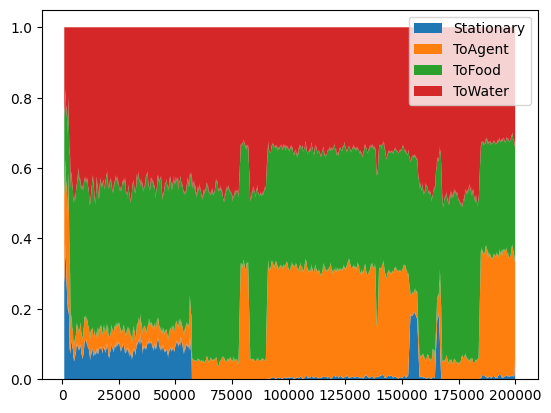

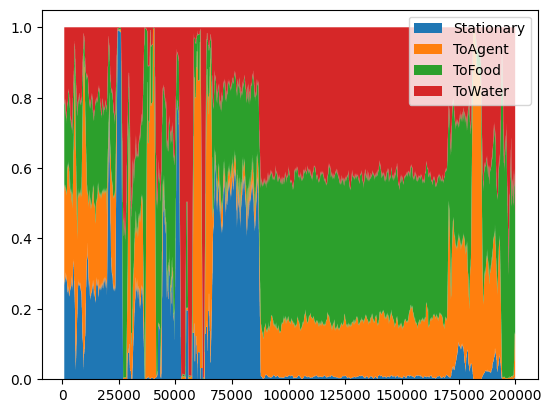

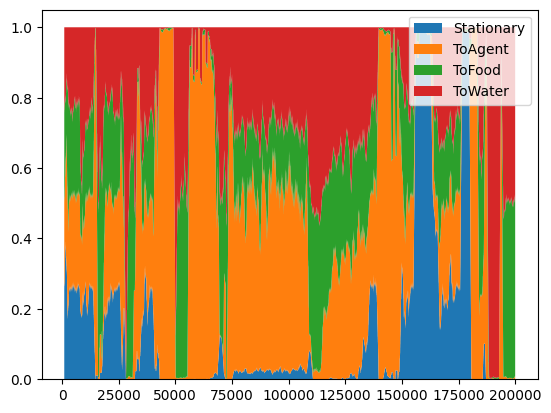

In [8]:
def plot_actions(df, agent_idx):
    acts = df.filter(pl.col("agent_id") == agent_idx).select(
        ["Stationary", "ToAgent", "ToFood", "ToWater"]
    )
    plt.stackplot(
        np.arange(acts.shape[0]),
        *acts.select(pl.col("*").rolling_mean(window_size=1000)).to_numpy().T,
        labels=acts.columns
    )
    plt.legend()
    plt.show()


# Plot 5 agents
for i in range(N_AGENTS):
    plot_actions(df, i)

In [9]:
def get_hist(
    df: pl.DataFrame, agent_idx: int, board_size: Tuple[int, int] = (20, 20)
) -> np.array:
    # Gets 2D array of visits to each cell
    hist = (
        df.filter(pl.col("time") > pl.col("time").max() / 2)
        .groupby(["agent_id", "x", "y"])
        .count()
    )
    hist_mat = np.zeros((20, 20))
    for row in hist.filter(pl.col("agent_id") == agent_idx).iter_rows(named=True):
        hist_mat[row["y"], row["x"]] += row["count"]
    return hist_mat

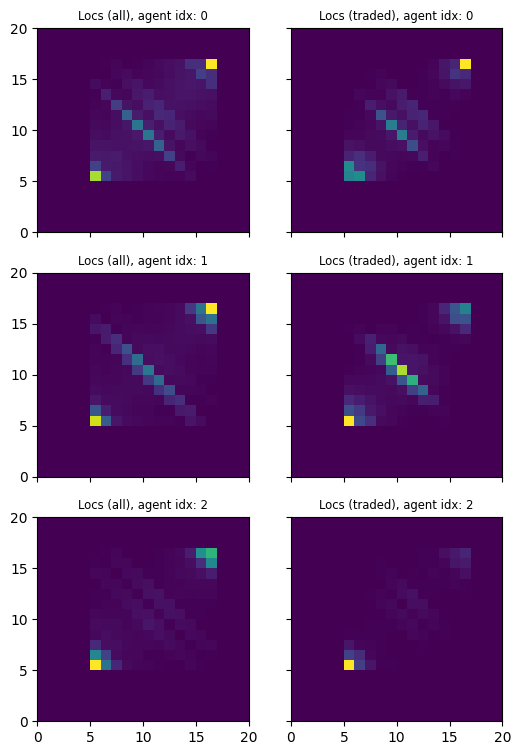

In [10]:
fig, axs = plt.subplots(N_AGENTS, 2, sharex=True, sharey=True)
fig.set_size_inches((6, 6*N_AGENTS/2))
for agent_idx in range(N_AGENTS):
    axs[agent_idx, 0].pcolormesh(get_hist(df, agent_idx))
    axs[agent_idx, 1].pcolormesh(get_hist(df.filter(pl.col("id") != None), agent_idx))
    axs[agent_idx, 0].set_title(f"Locs (all), agent idx: {agent_idx}", size="small")
    axs[agent_idx, 1].set_title(f"Locs (traded), agent idx: {agent_idx}", size="small")
plt.show()